C:\Users\Movahed\AppData\Local\Temp\ipykernel_11816\2572235415.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='ffill').fillna(method='bfill')


Evaluation):
  MSE: 11469354.4598
  MAE: 2808.0343
  R² : 0.6052


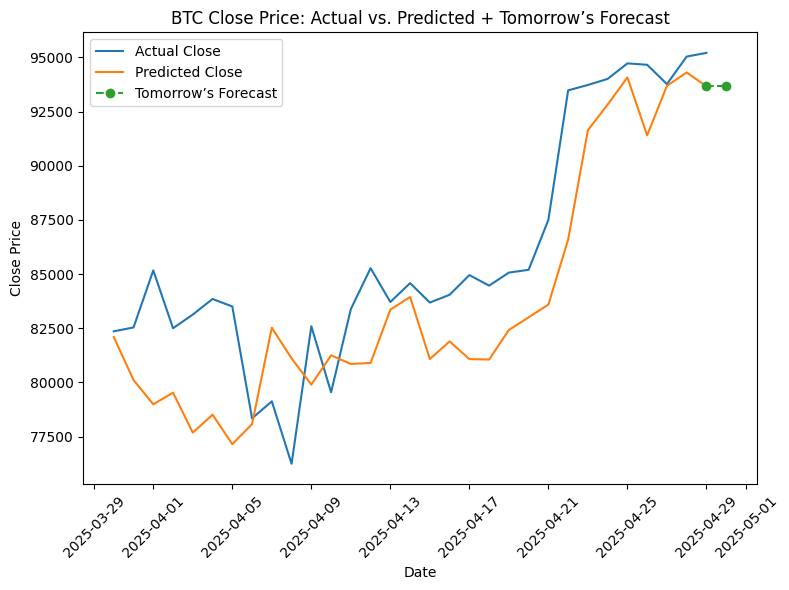

Predicted BTC Close on 2025-04-30: $93667.86


In [ ]:
# Training XGBoost 

import pandas as pd
import numpy as np
from datetime import timedelta
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1) Loading dataset
df = pd.read_csv('../output/btc_final.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

# 2) Cleaning up unwanted cols
drop_cols = [c for c in df.columns if 'Unnamed' in c or c == 'Datetime_UTC']
df.drop(columns=drop_cols, inplace=True)

# 3) Features
historical_features = ['Open', 'High', 'Low', 'Close', 'Volume']
indicator_features = [
    'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50', 'SMA_100', 'EMA_100', 'SMA_200', 'EMA_200',
    'SMA_Golden_Cross', 'SMA_Death_Cross', 'SMA_Cross_Signal',
    'EMA_Golden_Cross', 'EMA_Death_Cross', 'EMA_Cross_Signal',
    'RSI_14', 'RSI_Signal', 'RSI_Crossover',
    'STD_20', 'Upper_Band_20', 'Lower_Band_20',
    'Daily_Return', 'Cumulative_Return', 'Volatility_14', 'Vol_Category',
    'MACD', 'MACD_Signal', 'MACD_Histogram',
    'High_Low_Spread', 'High_Low_Percent'
]
sentiment_features = [
    'positive', 'neutral', 'negative', 'news_count',
    'finbert_sentiment', 'avg_sentiment',
    'fear_greed_index', 'fear_greed_label'
]
derivatives_features = [
    'open_interest', 'high_oi', 'low_oi', 'close_oi',
    'open_rate', 'high_rate', 'low_rate', 'close_rate',
    'long_liq', 'short_liq', 'long_ratio', 'short_ratio'
]

feature_cols = [c for c in (historical_features + indicator_features + sentiment_features + derivatives_features)
                if c in df.columns]

# 4) Encoding categoricals and fill missing
for col in feature_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

df[feature_cols] = df[feature_cols].fillna(method='ffill').fillna(method='bfill')

# 5) Creating next‐day target
original_last_date = df.index.max()
df['Close_next'] = df['Close'].shift(-1)

# 6) drop last row and NaNs
df = df.dropna(subset=['Close_next'] + feature_cols)

# 7) X and Y
X = df[feature_cols]
y = df['Close_next']

# 8) Split into train / test
last_month_start = original_last_date - pd.DateOffset(months=1)
train_mask = df.index < last_month_start

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[~train_mask], y[~train_mask]

# 9) Training XGBoost
model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# 10) Evaluation
preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
r2  = r2_score(y_test, preds)

print("Evaluation):")
print(f"  MSE: {mse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R² : {r2:.4f}")

# 11) Plot Actual vs Predicted
test_pred_index = y_test.index + timedelta(days=1)
next_date = original_last_date + timedelta(days=1)
pred_next_day = model.predict(X.iloc[[-1]])[0]

plt.figure(figsize=(8, 6))

plt.plot(test_pred_index, y_test.values, label='Actual Close')
plt.plot(test_pred_index, preds,     label='Predicted Close')

# 11.1) Dotted line for tomorrow's
plt.plot(
    [test_pred_index[-1], next_date],
    [preds[-1], pred_next_day],
    linestyle='--',
    marker='o',
    label='Tomorrow’s Forecast'
)

plt.title('BTC Close Price: Actual vs. Predicted + Tomorrow’s Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 12) Printing the forecast
print(f"Predicted BTC Close on {next_date.date()}: ${pred_next_day:.2f}")